In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.f2py.crackfortran import true_intent_list
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error



# 1. Load data

In [33]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("train:", train.shape)
print("test:", test.shape)

train: (750000, 12)
test: (250000, 11)


 # 2. EDA: Basic Exploration

In [34]:
print(train.isnull().sum())

display(train.describe())

categorical_features = [
    'Podcast_Name', 'Episode_Title', 'Genre',
    'Publication_Day', 'Publication_Time',
    'Episode_Sentiment'
]

for col in categorical_features:
    print(f"\n{col} — unique:", train[col].nunique())


id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64


,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000



Podcast_Name — unique: 48

Episode_Title — unique: 100

Genre — unique: 10

Publication_Day — unique: 7

Publication_Time — unique: 4

Episode_Sentiment — unique: 3


# 3. Preprocess

In [35]:
missing_values_columns = ["Episode_Length_minutes", "Number_of_Ads"]


for col in missing_values_columns:
    train[f'{col}_IS_IMPUTED'] = train[col].isnull().astype(int)
    test[f'{col}_IS_IMPUTED'] = test[col].isnull().astype(int)
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

# Guest/host popularity
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(0.0)
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(0.0)
train['Host_Popularity_percentage'] = train['Host_Popularity_percentage'].fillna(0.0)
test['Host_Popularity_percentage']  = test['Host_Popularity_percentage'].fillna(0.0)

# Episode_Title: fill in the blank rows for TF-IDF
train['Episode_Title'] = train['Episode_Title'].fillna('missing').astype(str)
test['Episode_Title']  = test['Episode_Title'].fillna('missing').astype(str)

eps = 1e-6
for df in (train, test):
    df['Popularity_Combined'] = df.get('Host_Popularity_percentage', 0.0) + df.get('Guest_Popularity_percentage', 0.0)
    df['Ads_per_Minute'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + eps)
    df['Ads_per_Minute'] = df['Ads_per_Minute'].fillna(0.0)
    df['Len_div_ads'] = df['Episode_Length_minutes'] / (df['Number_of_Ads'] + 1.0)
    df['Has_Guest'] = (df.get('Guest_Popularity_percentage', 0.0) > 0).astype(int)

def extract_episode_number_safe(title):
    if pd.isna(title):
        return 0
    m = re.search(r'(\d{1,5})\b(?!.*\d)', str(title))
    return int(m.group(1)) if m else 0

train['Episode_Number'] = train['Episode_Title'].apply(extract_episode_number_safe)
test['Episode_Number']  = test['Episode_Title'].apply(extract_episode_number_safe)

# Ads_Groups
bins = [ -1, 1, 2, 104 ]  # include -1 so 0 goes to first bin
labels = ['0-1', '1-2', '2+']
train['Ads_Groups'] = pd.cut(train['Number_of_Ads'], bins=bins, labels=labels)
test['Ads_Groups']  = pd.cut(test['Number_of_Ads'], bins=bins, labels=labels)
train['Ads_Groups'] = train['Ads_Groups'].fillna('0-1')
test['Ads_Groups']  = test['Ads_Groups'].fillna('0-1')


train = train[train['Episode_Length_minutes'] < 150 ]
test = test[test['Episode_Length_minutes'] < 150 ]

train = train[train['Listening_Time_minutes'] > 0]


In [ ]:
train = train.drop('Number_of_Ads', axis=1)
test = test.drop('Number_of_Ads', axis=1)
train = np.log1p(train['Listening_Time_minutes'])


In [ ]:
# train = np.log1p(train['Listening_Time_minutes'])
sns.histplot(data=train, x='Episode_Length_minutes')


In [12]:
train["Listening_Time_minutes"].value_counts()

Listening_Time_minutes
0.00000     8551
5.82000      124
10.55000     108
8.75000      108
19.71000      98
            ... 
90.89242       3
58.15856       3
50.74736       2
21.75737       2
69.18963       2
Name: count, Length: 42807, dtype: int64

Train

In [36]:
y = train['Listening_Time_minutes']
X = train.drop(columns=['id', 'Listening_Time_minutes'])


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2, # 20% for validation
    random_state=42 # for reproducible results
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print("y_train shape:", y_train.shape)


Train shape: (599999, 18), Validation shape: (150000, 18)
y_train shape: (599999,)


In [37]:
import lightgbm as lgb

encoder = {}
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

for col in categorical_features:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train[col].astype(str))
    X_val_enc[col] = le.transform(X_val[col].astype(str))
    encoder[col] = le

X_train_encoded = X_train_enc
X_val_encoded = X_val_enc

model = lgb.LGBMRegressor(
    random_state=42,
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1
)

model.fit(
    X_train_encoded,
    y_train,
    eval_set=[(X_val_encoded, y_val)],
    eval_metric='rmse',
    categorical_feature=categorical_features,
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

val_predictions = model.predict(X_val_encoded)
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

print(f"\n--- Model Evaluation ---")
print(f"Validation RMSE: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 599999, number of used features: 17
[LightGBM] [Info] Start training from score 45.437724

--- Model Evaluation ---
Validation RMSE: 12.9243


In [45]:
# -*- coding: utf-8 -*-
import re
import gc
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

RANDOM_STATE = 42

# -------------------------
# 0. Load
# -------------------------
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
print("train:", train.shape, "test:", test.shape)

# -------------------------
# 1. Basic processing and imputation
# -------------------------
# Pass flags + median (calculated on train)
missing_values_columns = ["Episode_Length_minutes", "Number_of_Ads"]
for col in missing_values_columns:
    train[f'{col}_IS_IMPUTED'] = train[col].isnull().astype(int)
    test[f'{col}_IS_IMPUTED'] = test[col].isnull().astype(int)
    med = train[col].median()
    train[col] = train[col].fillna(med)
    test[col]  = test[col].fillna(med)

# Guest/host popularity
train['Guest_Popularity_percentage'] = train['Guest_Popularity_percentage'].fillna(0.0)
test['Guest_Popularity_percentage'] = test['Guest_Popularity_percentage'].fillna(0.0)
train['Host_Popularity_percentage'] = train['Host_Popularity_percentage'].fillna(0.0)
test['Host_Popularity_percentage']  = test['Host_Popularity_percentage'].fillna(0.0)

# Episode_Title: fill in the blank rows for TF-IDF
train['Episode_Title'] = train['Episode_Title'].fillna('missing').astype(str)
test['Episode_Title']  = test['Episode_Title'].fillna('missing').astype(str)

# -------------------------
# 2. Derived features
# -------------------------
eps = 1e-6
for df in (train, test):
    df['Popularity_Combined'] = df.get('Host_Popularity_percentage', 0.0) + df.get('Guest_Popularity_percentage', 0.0)
    df['Ads_per_Minute'] = df['Number_of_Ads'] / (df['Episode_Length_minutes'] + eps)
    df['Ads_per_Minute'] = df['Ads_per_Minute'].fillna(0.0)
    df['Len_div_ads'] = df['Episode_Length_minutes'] / (df['Number_of_Ads'] + 1.0)
    df['Has_Guest'] = (df.get('Guest_Popularity_percentage', 0.0) > 0).astype(int)

# Episode number — more reliable parsing of the last number in the header
def extract_episode_number_safe(title):
    if pd.isna(title):
        return 0
    m = re.search(r'(\d{1,5})\b(?!.*\d)', str(title))
    return int(m.group(1)) if m else 0

train['Episode_Number'] = train['Episode_Title'].apply(extract_episode_number_safe)
test['Episode_Number']  = test['Episode_Title'].apply(extract_episode_number_safe)

# Ads_Groups: binnin
bins = [ -1, 1, 2, 104 ]  # include -1 so 0 goes to first bin
labels = ['0-1', '1-2', '2+']
train['Ads_Groups'] = pd.cut(train['Number_of_Ads'], bins=bins, labels=labels)
test['Ads_Groups']  = pd.cut(test['Number_of_Ads'], bins=bins, labels=labels)
train['Ads_Groups'] = train['Ads_Groups'].fillna('0-1')
test['Ads_Groups']  = test['Ads_Groups'].fillna('0-1')

# -------------------------
# 3. Category processing (LabelEncoder)
# -------------------------
from sklearn.preprocessing import LabelEncoder

# --- NEW: ADDED 'Podcast_Name' and 'Time_of_Week' ---
# (First, make sure to add 'Podcast_Name' fillna in Section 1
#  and 'Time_of_Week' creation in Section 2)

# Create Time_of_Week in Section 2
for df in (train, test):
    df['Time_of_Week'] = df['Publication_Day'].astype(str) + '_' + df['Publication_Time'].astype(str)

# Add Podcast_Name fillna in Section 1
train['Podcast_Name'] = train['Podcast_Name'].fillna('missing').astype(str)
test['Podcast_Name']  = test['Podcast_Name'].fillna('missing').astype(str)


categorical_small = [
    'Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time',
    'Episode_Sentiment', 'Ads_Groups', 'Time_of_Week'
]

for col in categorical_small:
    if col in train.columns:
        le = LabelEncoder()
        all_values = pd.concat([train[col].astype(str), test[col].astype(str)], axis=0)
        le.fit(all_values)
        train[col + '_le'] = le.transform(train[col].astype(str))
        test[col + '_le']  = le.transform(test[col].astype(str))

# -------------------------
# 4. TF-IDF for Episode_Title
# -------------------------
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=3)
all_titles = pd.concat([train['Episode_Title'], test['Episode_Title']], axis=0)
tfidf.fit(all_titles)
X_tfidf_train = tfidf.transform(train['Episode_Title'])
X_tfidf_test  = tfidf.transform(test['Episode_Title'])

# -------------------------
# 5.final features
# -------------------------
tab_features = [
    'Episode_Length_minutes','Episode_Length_minutes_IS_IMPUTED',
    'Guest_Popularity_percentage','Host_Popularity_percentage',
    'Popularity_Combined','Ads_per_Minute','Len_div_ads',
    'Episode_Number','Has_Guest'
]
# add coded categorical
tab_features += [c + '_le' for c in categorical_small]

# Ensure that all columns are present
tab_features = [c for c in tab_features if c in train.columns]

X_tab_train = train[tab_features].reset_index(drop=True)
X_tab_test  = test[tab_features].reset_index(drop=True)
y = train['Listening_Time_minutes'].values  # target at original scale

# -------------------------
# 6. Combining sparse TF-IDF and tabular features
# -------------------------
X_tab_train_sparse = sparse.csr_matrix(X_tab_train.values)
X_tab_test_sparse  = sparse.csr_matrix(X_tab_test.values)

X_train_full = sparse.hstack([X_tab_train_sparse, X_tfidf_train]).tocsr()
X_test_full  = sparse.hstack([X_tab_test_sparse, X_tfidf_test]).tocsr()

del X_tab_train_sparse, X_tab_test_sparse, X_tfidf_train, X_tfidf_test
gc.collect()

# -------------------------
# 7. Train/val sampling (fear: stratify by no — we use simple splitting with seed)
# -------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape, "y_val shape:", y_val.shape)

# -------------------------
# 8. LightGBM training on sparse data (without log transformation)
# -------------------------
model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE,
    n_estimators=10000,
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1
)

# LightGBM works correctly with scipy.sparse
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# -------------------------
# 9.  RMSE
# -------------------------
val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {rmse:.6f}")

# -------------------------
# 10. pred for test (
# -------------------------
test_pred = model.predict(X_test_full, num_iteration=model.best_iteration_)
# savaing
if 'id' in test.columns:
    sub = pd.DataFrame({'id': test['id'].values, 'Listening_Time_minutes': test_pred})
    sub.to_csv('submission.csv', index=False)
    print("Saved submission.csv")

# cleaning
del X_train_full, X_test_full, X_train, X_val
gc.collect()

train: (750000, 12) test: (250000, 11)
X_train shape: (600000, 199) X_val shape: (150000, 199)
y_train shape: (600000,) y_val shape: (150000,)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6761]	valid_0's rmse: 12.8383	valid_0's l2: 164.822


/Users/maxxxxx/PyCharmMiscProject/.venv/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation RMSE: 12.838306


/Users/maxxxxx/PyCharmMiscProject/.venv/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Saved submission.csv


75

Generating diagnostic plots...
Saved 1_original_prediction_vs_true.png
Saved 2_original_residuals_vs_predicted.png
Saved 3_original_residual_distribution.png
Error generating plots: Rectangle.set() got an unexpected keyword argument 'feature_name'
Plotting skipped.


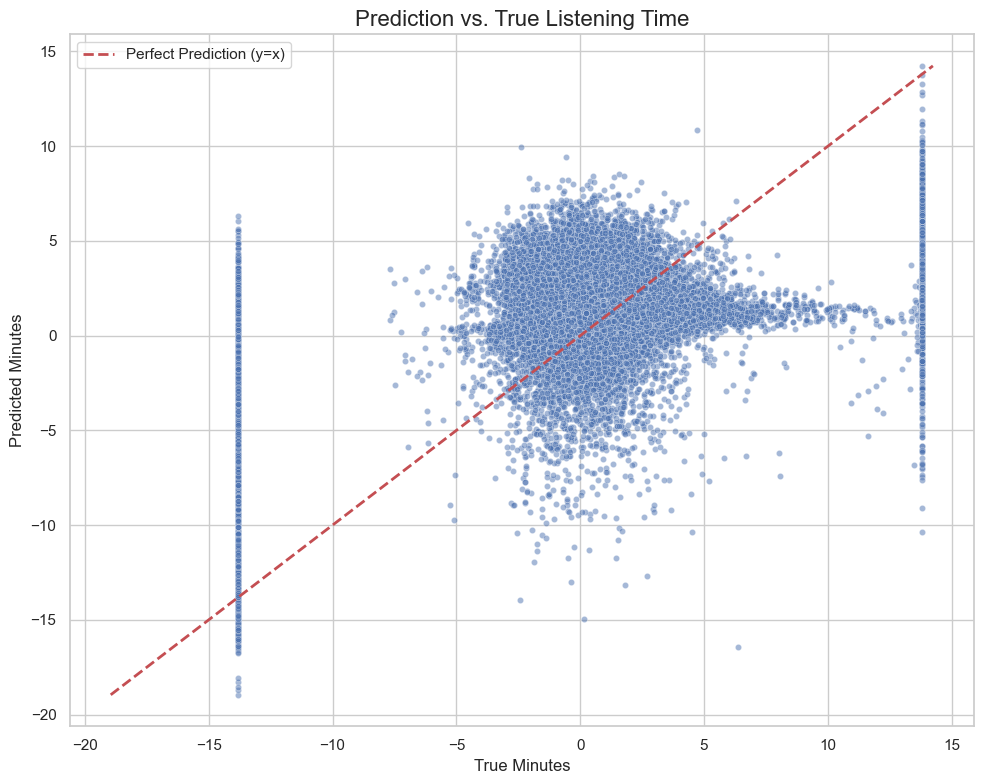

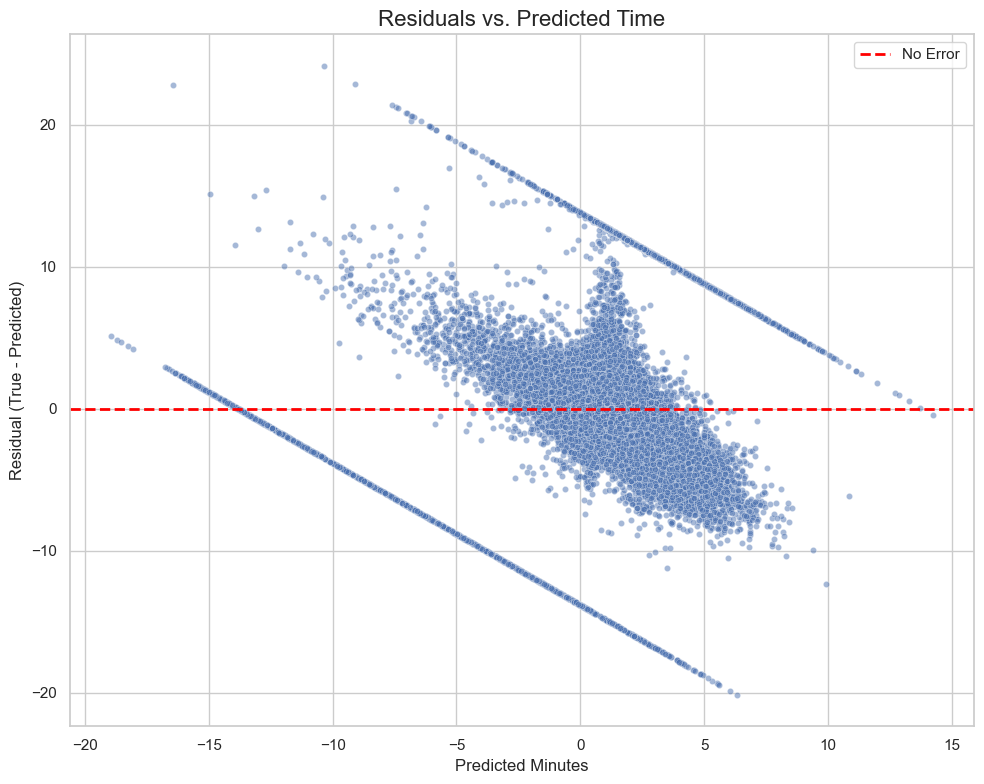

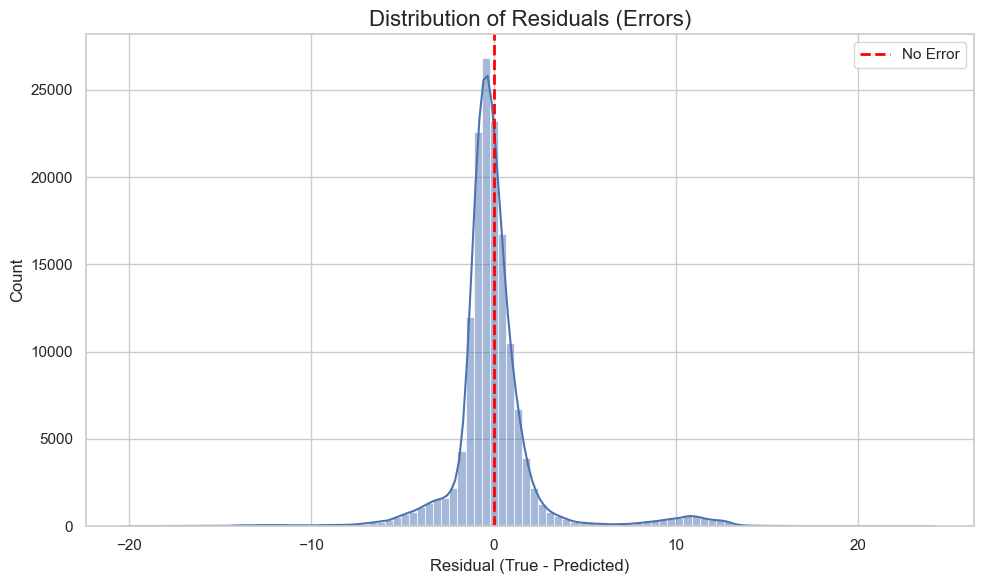

<Figure size 1000x1500 with 0 Axes>

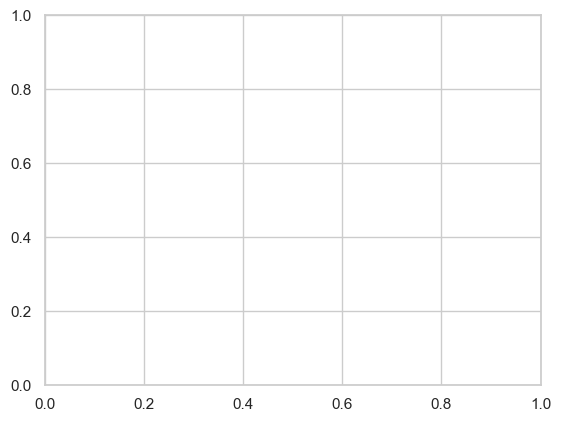

In [42]:
# -------------------------------------
# START: PLOTTING BLOCK
# -------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating diagnostic plots...")

# Create a DataFrame for easier plotting
val_df = pd.DataFrame({
    'True_Minutes': y_val,
    'Predicted_Minutes': val_pred
})
val_df['Residual'] = val_df['True_Minutes'] - val_df['Predicted_Minutes']

# Set plot style
sns.set_theme(style="whitegrid")

# ---------------------------------
# Plot 1: Prediction vs. True Values
# ---------------------------------
try:
    plt.figure(figsize=(10, 8))
    # Create a scatterplot
    sns.scatterplot(
        x='True_Minutes',
        y='Predicted_Minutes',
        data=val_df,
        alpha=0.5,  # Use transparency to see density
        s=20        # Smaller marker size
    )

    # Add a 45-degree reference line (where y = x)
    max_val = max(val_df['True_Minutes'].max(), val_df['Predicted_Minutes'].max())
    min_val = min(val_df['True_Minutes'].min(), val_df['Predicted_Minutes'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

    plt.title('Prediction vs. True Listening Time', fontsize=16)
    plt.xlabel('True Minutes', fontsize=12)
    plt.ylabel('Predicted Minutes', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig('1_original_prediction_vs_true.png')
    print("Saved 1_original_prediction_vs_true.png")

    # ---------------------------------
    # Plot 2: Residual vs. Predicted Values
    # ---------------------------------
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='Predicted_Minutes',
        y='Residual',
        data=val_df,
        alpha=0.5,
        s=20
    )

    # Add a horizontal line at 0 (no error)
    plt.axhline(0, ls='--', lw=2, color='red', label='No Error')

    plt.title('Residuals vs. Predicted Time', fontsize=16)
    plt.xlabel('Predicted Minutes', fontsize=12)
    plt.ylabel('Residual (True - Predicted)', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig('2_original_residuals_vs_predicted.png')
    print("Saved 2_original_residuals_vs_predicted.png")

    # ---------------------------------
    # Plot 3: Distribution of Residuals
    # ---------------------------------
    plt.figure(figsize=(10, 6))
    sns.histplot(val_df['Residual'], kde=True, bins=100)
    plt.title('Distribution of Residuals (Errors)', fontsize=16)
    plt.xlabel('Residual (True - Predicted)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.axvline(0, ls='--', lw=2, color='red', label='No Error')
    plt.legend()
    plt.tight_layout()
    plt.savefig('3_original_residual_distribution.png')
    print("Saved 3_original_residual_distribution.png")

    # ---------------------------------
    # Plot 4: Feature Importance
    # ---------------------------------
    # Get TF-IDF feature names
    tfidf_feature_names = list(tfidf.get_feature_names_out())

    # 'tab_features' was defined in Section 5
    all_feature_names = tab_features + tfidf_feature_names

    # Plot
    plt.figure(figsize=(10, 15))
    lgb.plot_importance(
        model,
        max_num_features=50,  # Show top 50
        height=0.8,
        importance_type='gain', # 'gain' is most informative
        feature_name=all_feature_names,
        title='Top 50 Feature Importances (by Gain)'
    )
    plt.tight_layout()
    plt.savefig('4_original_feature_importance.png')
    print("Saved 4_original_feature_importance.png")

    print("All plots saved.")

except Exception as e:
    print(f"Error generating plots: {e}")
    print("Plotting skipped.")

# -------------------------------------
# END: PLOTTING BLOCK
# -------------------------------------